## Compute vertical potential vorticity with velocities and density <br>
\begin{equation}
pv = -\frac{g}{\rho_{0}}(f + \zeta)\frac{\partial \rho}{\partial z}
\end{equation}

where $g=9.8 m/s^{2}$; <br> 
$\rho_{0}=1035 kg/m^{3}$; <br>
$\zeta$ is relative vorticity,$\zeta=\frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}$; <br>
$f$ is Coriolis $f = 2\omega sin\theta$, $\omega=7.292e-5$ 

In [3]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
from glob import glob
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
import matplotlib
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
import warnings
warnings.filterwarnings('ignore')

In [4]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
land=cft.NaturalEarthFeature('physical','land','110m',
                            edgecolor='black',facecolor='gray',
                            linewidth=0.5)
font={'family':'normal',
     'weight':'bold',
     'size':16}
matplotlib.rc('font',**font)

In [6]:
WBC=OrderedDict([
    ('eac', {'region':[145-360,174-360,-48,-20], 'x':slice(145-360,174-360),
                    'y': slice(-48,-20)}),
    ('gs',  {'region':[-82,-62,22,46], 'x':slice(-82,-62),
                    'y': slice(22,46)}),
    ('kc',  {'region':[130-360,155-360,28,45], 'x':slice(130-360,155-360),
                    'y': slice(28,45)})
])

In [7]:
session = cc.database.create_session()

In [10]:
def PV_separation_input(time):
    
    print('loading density...')
    rho=cc.querying.getvar(expt,'pot_rho_2',session,
                                 n=n_files,offset=offset)\
                                 .sel(xt_ocean=wbcx)\
                                 .sel(yt_ocean=wbcy)\
                                 .sel(time=time)
    print('loading u...')
    u=cc.querying.getvar(expt,'u',session,
                                 n=n_files,offset=offset)\
                                 .sel(xu_ocean=wbcx)\
                                 .sel(yu_ocean=wbcy)\
                                 .sel(time=time)
    print('loading v...')
    v=cc.querying.getvar(expt,'v',session,
                                 n=n_files,offset=offset)\
                                 .sel(xu_ocean=wbcx)\
                                 .sel(yu_ocean=wbcy)\
                                 .sel(time=time)
    return rho,u,v

RV: year-mean relative vorticity: $\overline{\zeta} =\overline{ -\frac{\partial u}{\partial y}+\frac{\partial v}{\partial x}}$ <br>
buofre: year-mean vertical density gradient $\overline{\frac{\partial \rho}{\partial z}}$ <br>
PV:year-mean vertical potential vorticity (computed with velocities and density)$\overline{-\frac{g}{\rho_0}(f+\zeta)\frac{\partial \rho}{\partial z}}$

In [11]:
def PV_separation(u_whole,v_whole,rho_whole):
    ysize=rho_whole.shape[2]-2
    xsize=rho_whole.shape[3]-1
    zsize=rho_whole.shape[1]
    z=rho_whole.st_ocean.values# z axes of tcell
    dz=z[1:]-z[0:-1]# compute height of grid with st_ocean
    dz3d=np.tile(dz,(ysize,xsize,1))
    dz3dd=np.transpose(dz3d,(2,0,1))# make it a 3d array
    
    
    #z=rho_yr.st_ocean.values# z axes of tcell
    #dz=z[1:75]-z[0:-1]# compute height of grid with st_ocean
    #dz3d=np.tile(dz,(343,289,1))
    #dz3dd=np.transpose(dz3d,(2,0,1))# make it a 3d array
    ## assign 3d arrays to store year-mean rv, dendity gradient and pv
    zeta_whole=np.zeros((zsize,ysize,xsize))
    rho_grad_whole=np.zeros((zsize-1,ysize,xsize))
    pv_rep_whole=np.zeros((zsize-1,ysize,xsize))
    realrv_whole=np.zeros((zsize-1,ysize,xsize))
    planetary_whole=np.zeros((zsize-1,ysize,xsize))
    #Coriolis
    theta=dytnew['yt_ocean']*math.pi/180
    omega=7.292e-5
    f=2*omega*np.sin(theta)
    f3d=np.tile(f,(zsize-1,xsize,1))
    f3dd=np.transpose(f3d,(0,2,1))# make it a 3d array
    Coriolis=xr.DataArray(f3dd,
                        coords=[rho_whole['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean'][0:-1]])
    #calculate rv, density gradient and pv every month
    T=len(rho_whole['time'])
    for m in range(0,T):
        print('computing',str(m+1),'in',str(T))
        rho = rho_whole.isel(time=m)\
                    .isel(yt_ocean=slice(1,-1))\
                    .isel(xt_ocean=slice(0,-1))
        u = u_whole.isel(time=m)
        v = v_whole.isel(time=m)
        #Relative vorticity every month
        dv = v.values[:,:,1:]-v.values[:,:,0:-1]
        dv_dx=dv/dxtnew3d
        dv_dx_mean = 1/2*(dv_dx[:,1:,:]+dv_dx[:,0:-1,:])
        du = u.values[:,1:,:]-u.values[:,0:-1,:]
        du_dy = du/dytnew3d
        du_dy_mean = 1/2*(du_dy[:,:,0:-1]+du_dy[:,:,1:])
        zeta = dv_dx_mean-du_dy_mean
        
        #density gradient every month
        drho=rho.values[0:-1,:,:]-rho.values[1:,:,:]
        drho_dz=drho/dz3dd
        # potential vorticity (computed with density and velocities) every month
        pv_rep=-9.8/1035*(f3dd+zeta[0:-1])*drho_dz
        realrv=-9.8/1035*(zeta[0:-1])*drho_dz
        planetary=-9.8/1035*(f3dd)*drho_dz
        #year-mean relative vorticity
        zeta_whole=zeta_whole+zeta/T
        rho_grad_whole=rho_grad_whole+drho_dz/T
        pv_rep_whole=pv_rep_whole+pv_rep/T
        realrv_whole=realrv_whole+realrv/T
        planetary_whole=planetary_whole+planetary/T
    RV=xr.DataArray(zeta_whole
                    ,coords=[v['st_ocean'],dytnew['yt_ocean'],dytnew['xt_ocean'][0:-1]])
    buofre=xr.DataArray(rho_grad_whole,
                        coords=[v['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean'][0:-1]])
    PV = xr.DataArray(pv_rep_whole,
                        coords=[v['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean'][0:-1]])
    RealRV=xr.DataArray(realrv_whole,
                        coords=[v['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean'][0:-1]])
    Planetary=xr.DataArray(planetary_whole,
                        coords=[v['st_ocean'][0:-1],
                                dytnew['yt_ocean'],dytnew['xt_ocean'][0:-1]])
    return RV,buofre,PV,RealRV,Planetary

## EAC PV components for 1999-2009

In [16]:
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']

time=slice('1999-01-01','2009-01-01')

region=WBC['eac']['region']
wbcx=WBC['eac']['x']
wbcy=WBC['eac']['y']

zsize=75
grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
dxt=grid.dxt.sel(xt_ocean=wbcx)\
        .sel(yt_ocean=wbcy)
dyt = grid.dyt.sel(xt_ocean=wbcx)\
            .sel(yt_ocean=wbcy)
dytnew=dyt[1:-1,:]#trim the grid array to make it has the same size with u and v 
dxtnew=dxt[0:-1,0:-1]#trim the grid array to make it has the same size with u and v 
dxtnew3d=np.tile(dxtnew.values,(zsize,1,1))
dytnew3d=np.tile(dytnew.values,(zsize,1,1))


rho,u,v=PV_separation_input(time)
RV,buofre,PV,RealRV,Planetary = PV_separation(u,v,rho)

## PV separation averaged on 1999-2009

In [13]:
# time-mean vert_pv over the 1999-2009
warnings.filterwarnings('ignore')
pv_tm=cc.querying.getvar(expt,'vert_pv',session,
                     n=n_files,offset=offset)\
                     .sel(xt_ocean=wbcx)\
                     .sel(yt_ocean=wbcy)\
                     .sel(time=time)\
                     .mean('time')

Text(0,1,'(d)')

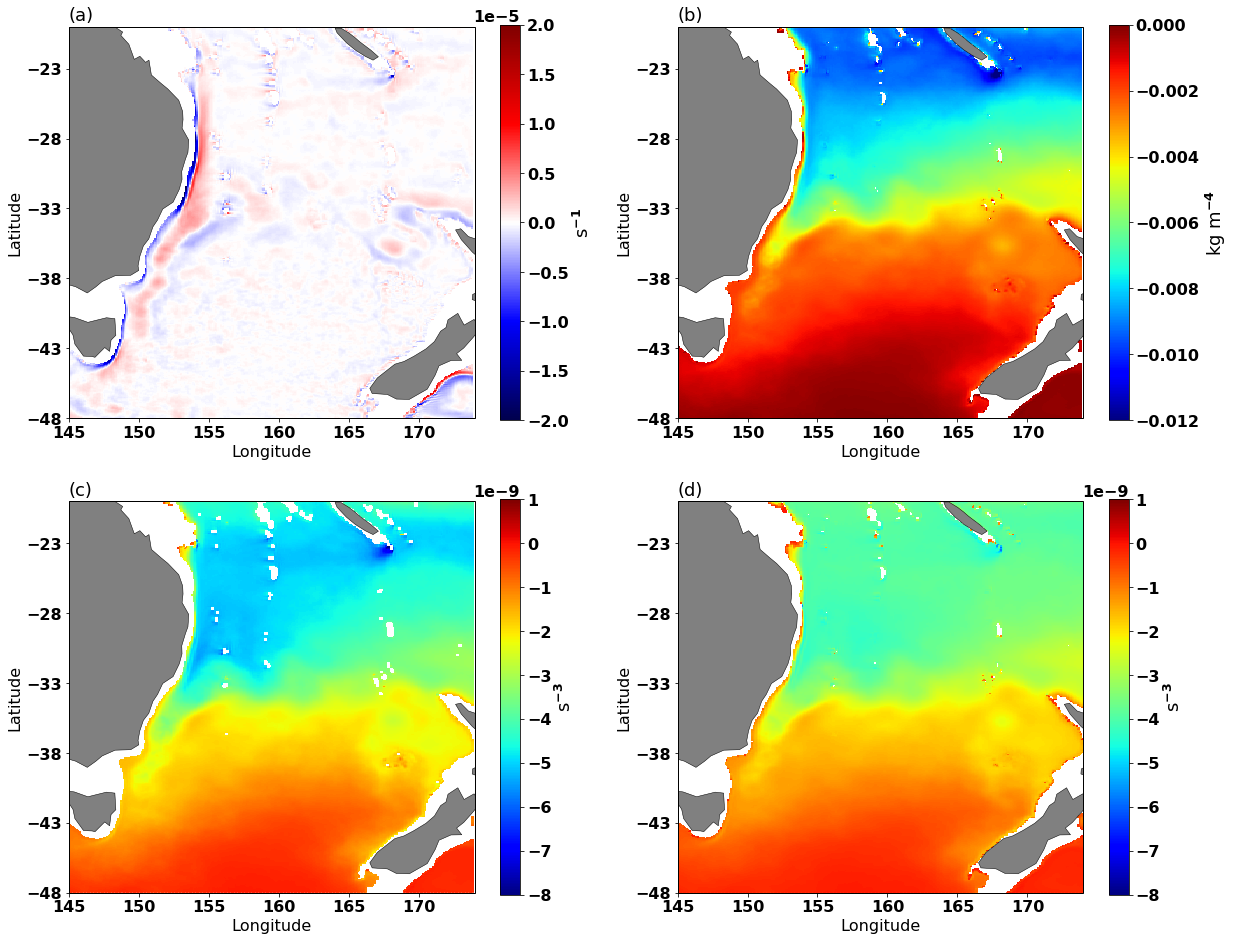

In [14]:
RV_mean_xr=RV
buofre_mean_xr=buofre
PV_mean_xr=PV
d=400
fig=plt.figure(figsize=(20,16))
ax0=fig.add_subplot(2,2,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p1=plt.pcolormesh(RV_mean_xr['xt_ocean'],RV_mean_xr['yt_ocean'],
                  RV_mean_xr.sel(st_ocean=d,method='nearest'),cmap='seismic',vmin=-2e-5,vmax=2e-5)
cb1=fig.colorbar(p1)
cb1.formatter.set_powerlimits((0, 0))
cb1.update_ticks()
cb1.ax.set_ylabel('s$^{-1}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)

ax0=fig.add_subplot(2,2,2,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p2=plt.pcolormesh(buofre_mean_xr['xt_ocean'],buofre_mean_xr['yt_ocean'],
               buofre_mean_xr.sel(st_ocean=d,method='nearest').values
              ,cmap='jet',vmin=-1.2e-2,vmax=0)#vmax=0.4e-2
cb2=fig.colorbar(p2)
cb2.ax.set_ylabel('kg m$^{-4}$',fontsize=18)
cb2.formatter.set_powerlimits((0, 0))
cb1.update_ticks()
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(b)',loc='left',fontsize=18)


ax0=fig.add_subplot(2,2,3,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p3=PV_mean_xr.sel(st_ocean=d,method='nearest').plot(cmap='jet',vmin=-8e-9,vmax=1e-9,add_colorbar=False)#vmax=4e-9
cb3=fig.colorbar(p3)
cb3.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(c)',loc='left',fontsize=18)


ax0=fig.add_subplot(2,2,4,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(wbcx.start,wbcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(wbcy.start,wbcy.stop+1,5), crs=ccrs.PlateCarree())
p4=pv_tm.sel(st_ocean=d,method='nearest').plot(cmap='jet',vmin=-8e-9,vmax=1e-9,add_colorbar=False)#vmax=4e-9
cb4=fig.colorbar(p4)
cb4.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(d)',loc='left',fontsize=18)
#savefigure('PV_sep_EAC')

Text(0,1,'(b)')

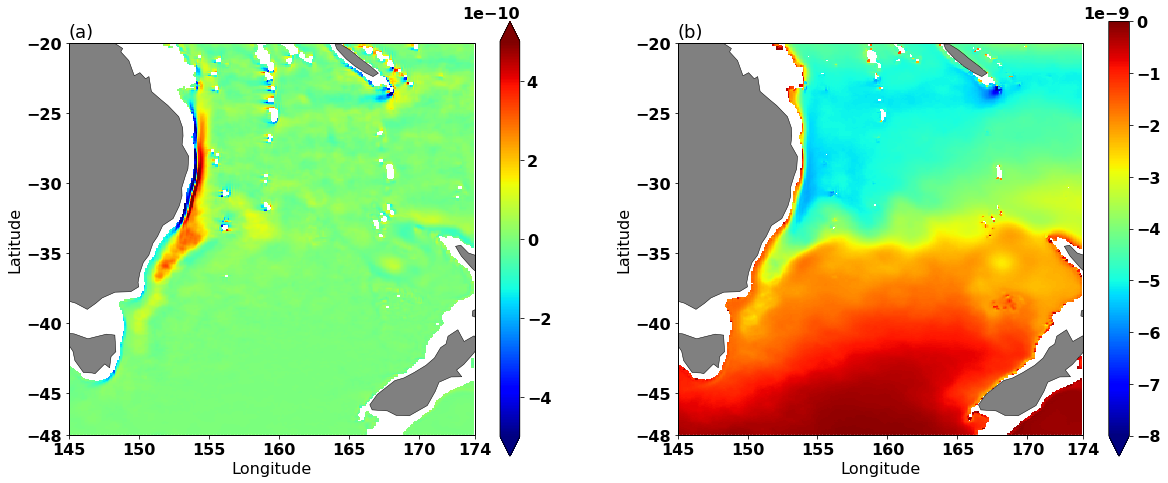

In [15]:
d=400
fig=plt.figure(figsize=(20,8))
ax0=fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
ax0.set_extent([145,174, -48,-20], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([145,150,155,160,165,170,174], crs=ccrs.PlateCarree())
ax0.set_yticks([-48,-45,-40,-35,-30,-25,-20], crs=ccrs.PlateCarree())
p3=RealRV.sel(st_ocean=d,method='nearest').plot(cmap='jet',vmin=-5e-10,vmax=5e-10,add_colorbar=True)
#cb3=fig.colorbar(p3)
#cb3.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)


ax0=fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())
ax0.set_extent([145,174, -48,-20], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([145,150,155,160,165,170,174], crs=ccrs.PlateCarree())
ax0.set_yticks([-48,-45,-40,-35,-30,-25,-20], crs=ccrs.PlateCarree())
p4=Planetary.sel(st_ocean=d,method='nearest').plot(cmap='jet',vmin=-8e-9,vmax=0,add_colorbar=True)
#cb4=fig.colorbar(p4)
#cb4.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(b)',loc='left',fontsize=18)